In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Chemistry_PhD/MIE_atlas/')
sys.path.append('/content/drive/MyDrive/Chemistry_PhD/interpretability/models/')

!pip install shap
!pip install rdkit-pypi -qqq
!pip install xgboost
!pip install torchbnn


# custom import from MIE_atlas library
from featurizers.molfeaturizer import MorganFPFeaturizer
from bnnclass import BNNClassifier

import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

import shap
from shap import TreeExplainer, KernelExplainer, DeepExplainer

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Data setup

raw_data = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/data/combined_cleaned_data.csv')

smiles = raw_data['SMILES']
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)
X = featurizer.transform(smiles)
y = raw_data['Label'].values


[21:48:01] WARNING: not removing hydrogen atom without neighbors
[21:48:02] WARNING: not removing hydrogen atom without neighbors
[21:48:02] WARNING: not removing hydrogen atom without neighbors
[21:48:02] WARNING: not removing hydrogen atom without neighbors
[21:48:02] WARNING: not removing hydrogen atom without neighbors
[21:48:02] WARNING: not removing hydrogen atom without neighbors
[21:48:03] WARNING: not removing hydrogen atom without neighbors
[21:48:03] WARNING: not removing hydrogen atom without neighbors
[21:48:03] WARNING: not removing hydrogen atom without neighbors
[21:48:03] WARNING: not removing hydrogen atom without neighbors
[21:48:03] WARNING: not removing hydrogen atom without neighbors
[21:48:03] WARNING: not removing hydrogen atom without neighbors
[21:48:03] WARNING: not removing hydrogen atom without neighbors
[21:48:04] WARNING: not removing hydrogen atom without neighbors
[21:48:04] WARNING: not removing hydrogen atom without neighbors
[21:48:04] WARNING: not r

In [ ]:
mccs = dict()
balaccs = dict()
cms = dict()

X, y = shuffle(X, y, random_state = 1024)

skf = StratifiedKFold(n_splits = 5, shuffle = False, random_state = None)


for fold, (trains, tests) in enumerate(skf.split(X, y)): 

    print(f'Modelling fold {fold+1} of {skf.n_splits}...')

    X_train, X_test, y_train, y_test = X[trains], X[tests], y[trains], y[tests]

    gbc = XGBClassifier()
    gbc.fit(X_train, y_train)

    y_pred = gbc.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    balacc = balanced_accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    mccs[fold] = mcc
    balaccs[fold] = balacc
    cms[fold] = cm

    print(f'MCC: {mcc}')
    print(f'Bal Acc: {balacc}')
    print('Confusion matrix: ')
    print(cm)



Modelling fold 1 of 5...
MCC: 0.6257712202959732
Bal Acc: 0.8128444081984018
Confusion matrix: 
[[686 142]
 [173 680]]
Modelling fold 2 of 5...
MCC: 0.609574859598851
Bal Acc: 0.8046203793374903
Confusion matrix: 
[[685 143]
 [186 667]]
Modelling fold 3 of 5...
MCC: 0.6119562272100258
Bal Acc: 0.8058104105430677
Confusion matrix: 
[[686 142]
 [185 668]]
Modelling fold 4 of 5...
MCC: 0.6379069882270201
Bal Acc: 0.8184032173238771
Confusion matrix: 
[[706 121]
 [185 668]]
Modelling fold 5 of 5...
MCC: 0.6132493312168615
Bal Acc: 0.8066579155154792
Confusion matrix: 
[[673 154]
 [171 682]]


In [ ]:
print('KFold metrics:')
overall_mcc = np.mean(list(mccs.values()))
overall_balacc = np.mean(list(balaccs.values()))
print(f'Overall MCC: {overall_mcc}')
print(f'Overall Bal Acc: {overall_balacc}')

KFold metrics:
Overall MCC: 0.6196917253097464
Overall Bal Acc: 0.8096672661836631


In [ ]:
# ported to standalone package

import numpy as np
import scipy.stats as st

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps

class BNNClassifier(nn.Sequential): 
    
    """
    Wrapper class for Bayesian Neural Networks in PyTorch. 
    Designed for classification tasks. 
    Contains custom functions for model fitting, making predictions, uncertainty estimation and interpretation. 

    Core layers are from torchbnn (https://github.com/Harry24k/bayesian-neural-network-pytorch/)

    Example: 

    import torch
    import torchbnn as bnn
    import torch.nn as nn
    from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef

    model = BNNClassifier(
    bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 8000, out_features = 10),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 10, out_features = 10),
    nn.ReLU(), 
    bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 10, out_features = 2)
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model.set_hparams()
    model.fit(X_in, y_in)

    model.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

    y_pred = [int(x>0) for x in y_mu]
    print(balanced_accuracy_score(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))
    """


    def set_hparams(self, kl_weight = 0.1, optimizer = optim.Adam, lr = 0.01, epochs = 500): 
        # sets hyperparameters for model. do this before trying to fit. 
        self.kl_weight = kl_weight
        self.optimizer = optimizer(self.parameters(), lr = lr)
        self.epochs = epochs
    
    def fit(self, X, y): 
        # fit model parameters. 
        # X: input training data. 
        # y: input training labels. 
        # return None
        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        ce_loss = nn.CrossEntropyLoss()
        kl_loss = bnn.BKLLoss(reduction = 'mean',
                              last_layer_only=False)
        for epoch in range(self.epochs): 
            pre = self(X)
            ce = ce_loss(pre, y)
            kl = kl_loss(self)
            cost = ce + self.kl_weight*kl

            self.optimizer.zero_grad()
            cost.backward()
            self.optimizer.step()
    
    def predict_proba_once(self, X): 
        # get a single sample of the numerical output of the neural network before it is converted to predicted class. 
        # not strictly a "probability" but this is the closest interpretation to this value. 
        # X: input test data. 
        
        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        probs = self(X).data

        return (probs[:,1] - probs[:,0]).numpy()

    def predict_softmax_proba_once(self, X): 
        # convert a single sample of the numerical output of the neural network to a probability using softmax function (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html). 
        # X: input test data. 

        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        probs = self(X).data
        sm = nn.Softmax(dim=1)

        return sm(probs).numpy()

    def predict_once(self, X): 
        # convert a single sample of the numerical output of the neural network to a class prediction. 
        # X: input test data. 

        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        probs = self(X).data
        _, preds = torch.max(probs, 1)
        
        return preds.numpy()

    def sample_posterior(self, X, n_samples = 1000): 
        # sample and store the posterior distribution for making predictions. 
        # this can save time if working with the same test data to avoid resampling the same posterior repeatedly. 
        # X: input test data. 
        # n_samples: number of samples to take. more samples will lead to a more credible posterior but increase computing costs. 

        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        samples = np.zeros((len(X), n_samples))
        for i in range(n_samples): 
            samples[:,i] = np.squeeze(self.predict_proba_once(X))
        
        self.store_x = X
        self.samples = samples
        return samples


    def predict_normal_distribution(self, X, resample = True, n_samples = 1000): 
        # get mean and standard deviation for the posterior distribution. 
        # we have normal priors over the weights in the neural network, so we expect the posterior to be a normal distribution. 
        # X: input test data. 
        # resample: whether to sample again or to take the stored samples. 
        # n_samples: number of samples to take. 

        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        if not hasattr(self, 'store_x') or resample: 
            self.sample_posterior(X, n_samples)

        y_mu = np.array([np.mean(r) for r in self.samples])
        y_sigma = np.array([np.std(r) for r in self.samples])

        return y_mu, y_sigma

    def predict(self, X, resample = True, n_samples = 1000): 
        # predict classes for input test data. 
        # X: input test data
        # resample: whether to sample again or to take stored samples. 
        # n_samples: number of samples to take. 

        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        if not hasattr(self, 'store_x') or resample: 
            self.sample_posterior(X, n_samples)

        y_mu = np.array([np.mean(r) for r in self.samples])

        return np.array([int(x>0) for x in y_mu])



    def predict_proba(self, X, resample = True, n_samples = 1000): 
        # predict probability of being in the positive class. 
        # obtained by considering the posterior distribution and y_proba > 0 is required to be in the positive class. 
        # X: input test data
        # resample: whether to sample again or to take stored samples. 
        # n_samples: number of samples to take. 

        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        if not hasattr(self, 'store_x') or resample: 
            self.sample_posterior(X, n_samples)

        y_mu = np.array([np.mean(r) for r in self.samples])
        y_sigma = np.array([np.std(r) for r in self.samples])

        sfs = [st.norm.sf(0, y_mu[i], y_sigma[i]) for i in range(len(X))]

        return sfs


    def predict_softmax_proba(self, X, resample = True, n_samples = 1000): 
        # predict the softmax probability of being in the positive class, similar to predict_softmax_proba_once. 
        # X: input test data
        # resample: whether to sample again or to take stored samples. 
        # n_samples: number of samples to take

        if type(X) == np.ndarray: 
            X = torch.from_numpy(X).float()
        if not hasattr(self, 'store_x') or resample: 
            self.sample_posterior(X, n_samples)

        y_mu = np.array([np.mean(r) for r in self.samples])        
        
        def softmax(x): 
            return np.exp(x)/(1+np.exp(x))

        return [softmax(x) for x in y_mu]



    def config_explainer(self, explainer, sample_data): 
        # ONLY FOR SHAP
        # define which SHAP explainer to use. by default recommend DeepExplainer (although it spews a million warnings about BayesLinear)
        if type(sample_data) == np.ndarray: 
            sample_data = torch.from_numpy(sample_data).float()        
        self.explainer = explainer(self, sample_data)
        return None

    def explain_once(self, smiles, plot = False): 
        # explains model prediction using feature attributions by SHAP
        # distribute ECFP bit attributions to atoms to get atom attributions
        # smiles: input molecule to explain. need to use smiles because we need the original molecule to interpret ECFP bits. 
        # plot: whether to plot the resulting explanation. 

        if not hasattr(self, 'explainer'): 
            print('Define the explainer first with model.config_explainer before trying to explain model.')
            return None

        mol = Chem.MolFromSmiles(smiles)
        bi = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2, nBits = 8000, bitInfo = bi)

        X = np.array(fp.ToList())
        shapvs = self.explainer.shap_values(torch.from_numpy(X.reshape(1,-1)).float())
        bit_contr = np.squeeze(shapvs[1] - shapvs[0])*X
        atom_weights = [0] * mol.GetNumAtoms()

        for on_bit in bit_contr.nonzero()[0]: 
            n_occurrences = len(bi[on_bit])

            for example in range(n_occurrences): 
                central_atom, radius = bi[on_bit][example]
                m_env = set((central_atom,))
                bit_path = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, central_atom)

                for atom in bit_path: 
                    m_env.add(mol.GetBondWithIdx(atom).GetBeginAtomIdx())
                    m_env.add(mol.GetBondWithIdx(atom).GetBeginAtomIdx())

                bit_weight = bit_contr[on_bit]

                for atom in m_env: 
                    atom_weights[atom] += bit_weight / n_occurrences

        if plot: 
            weights, maxweight = SimilarityMaps.GetStandardizedWeights(atom_weights)
            fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, weights)

        else: 
            return atom_weights

    def explain(self, smiles, n_samples = 1000, plot = True): 
        # explains model prediction using feature attributions by SHAP
        # sample many times to get lower variance on SHAP values
        # smiles: input molecule to explain
        # n_samples: how many samples to take
        # plot: whether to plot the resulting explanation
        
        if not hasattr(self, 'explainer'): 
            print('Define the explainer first with model.config_explainer before trying to explain model.')
            return None

        mol = Chem.MolFromSmiles(smiles)
        samples = np.zeros((mol.GetNumAtoms(), n_samples))
        for i in range(n_samples): 
            samples[:,i] = self.explain_once(smiles, plot=False)

        atom_weight_mu = np.array([np.mean(r) for r in samples])
        atom_weight_sigma = np.array([np.std(r) for r in samples])

        if plot: 
            weights, maxweight = SimilarityMaps.GetStandardizedWeights(atom_weight_mu)
            fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, weights)
            return fig

        else: 
            return atom_weight_mu, atom_weight_sigma



    def rdkit_sim_map(self, smiles, n_samples = 1000, plot = True): 
        # explains model prediction using SimilarityMaps.GetAtomicWeightsForModel from rdkit (https://www.rdkit.org/docs/source/rdkit.Chem.Draw.SimilarityMaps.html). 
        # iterates through atoms one at a time, generating fingerprints without this atom and comparing the impact on the model prediction. 
        # this process includes sampling the neural network many times, so uncertainty within the network is accounted for. 
        # smiles: input molecule to explain
        # n_samples: how many samples to take
        # plot: whether to plot the resulting explanation

        def fpstring(mol, x): 
            probefp = SimilarityMaps.GetMorganFingerprint(mol, atomId=x, radius=2, fpType='bv', nBits=8000)
            probevect = np.zeros(8000)
            DataStructs.ConvertToNumpyArray(probefp, probevect)
            X_probe = np.expand_dims(probevect, axis = 0)
            return X_probe

        def get_mean_pred(X): 
            y_mu, y_sigma = self.predict_normal_distribution(X, resample = True, n_samples = 100)
            return y_mu

        mol = Chem.MolFromSmiles(smiles)
        

        if plot: 
            fig, maxweight = SimilarityMaps.GetSimilarityMapForModel(mol, fpstring, get_mean_pred)
            return fig
        
        else: 
            weights = SimilarityMaps.GetAtomicWeightsForModel(mol, fpstring, get_mean_pred)
            return weights


In [ ]:
model = BNNClassifier(
    bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 8000, out_features = 10),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 10, out_features = 10),
    nn.ReLU(), 
    bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 10, out_features = 10),
    nn.ReLU(), 
    bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 10, out_features = 2)
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# convert format of X and y to Tensor objects
X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
y_in = torch.from_numpy(y_train).long()

model.set_hparams()
model.fit(X_in, y_in)

model.sample_posterior(X_test, n_samples = 5000)
y_mu, y_sigma = model.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

y_pred = [int(x>0) for x in y_mu]
print(balanced_accuracy_score(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))

0.8011573188190104
0.6046978066779176


(array([5.50251424]), array([2.84143735]))
[0.9962569788507423]
[0.9755537068382502]


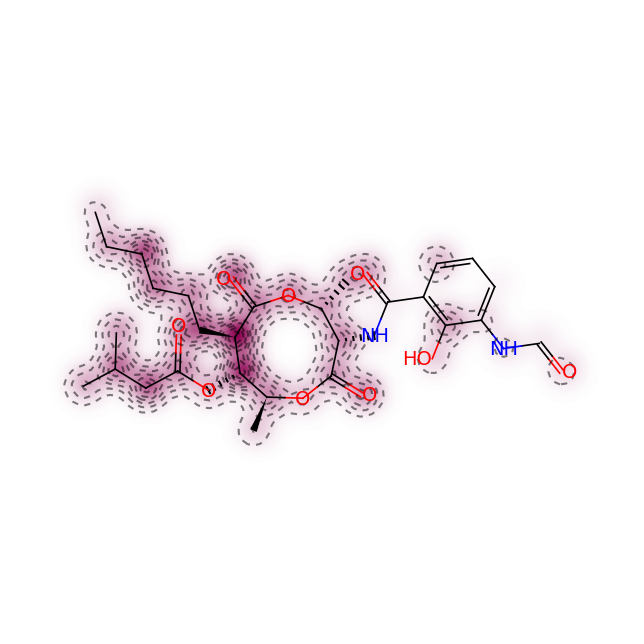

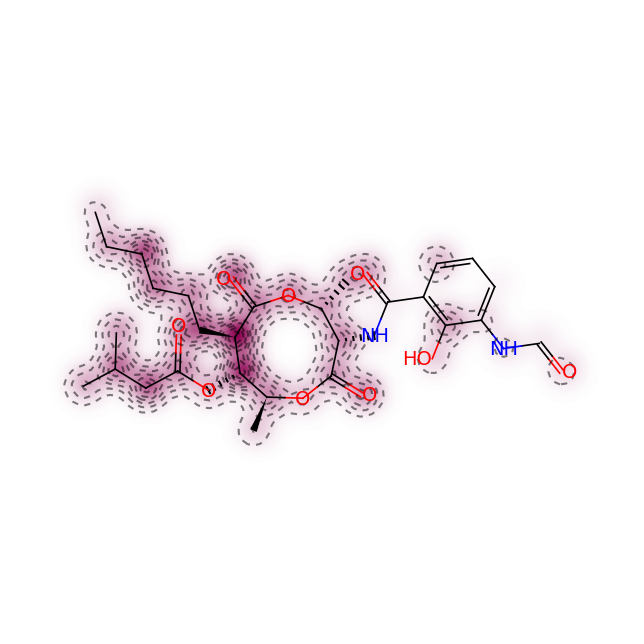

In [ ]:
print(model.predict_normal_distribution(X_test[0].reshape(1,-1)))
print(model.predict_softmax_proba(X_test[0].reshape(1,-1)))
print(model.predict_proba(X_test[0].reshape(1,-1)))
model.rdkit_sim_map('O=CNc1cccc(c1O)C(=O)N[C@@H]2C(=O)O[C@H]([C@H](OC(=O)CC(C)C)[C@H](C(=O)O[C@@H]2C)CCCCCC)C', plot = True)

In [ ]:
model.config_explainer(DeepExplainer, torch.from_numpy(shap.sample(X_test, 100)).float())
once_weights = model.explain_once('O=CNc1cccc(c1O)C(=O)N[C@@H]2C(=O)O[C@H]([C@H](OC(=O)CC(C)C)[C@H](C(=O)O[C@@H]2C)CCCCCC)C', plot = False)
weights_mu, weights_sigma = model.explain('O=CNc1cccc(c1O)C(=O)N[C@@H]2C(=O)O[C@H]([C@H](OC(=O)CC(C)C)[C@H](C(=O)O[C@@H]2C)CCCCCC)C', plot = False)

print(once_weights)
print(weights_mu, weights_sigma)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Streaming output truncated to the last 5000 lines.
[-0.6044758878648281, 0.4845777191221714, 0.6319067142903805, 0.5444621302187442, 0.7179002501070499, 0.798374529927969, -2.4972992492839694, -2.437587365694344, -0.1772182017564774, -1.1883511170744896, -1.4616825748234987, -0.18244052529335023, -2.0147377108223736, -2.2930785198695958, -0.11034965114668016, -0.017801469564437865, 0.8435418116860092, -4.115418445318937, -6.42387242987752, -1.0505115389823914, -1.3878033123910427, -0.18244052529335023, -0.9818260384102662, -1.7236762084066868, -0.7164495006203652, -0.7164495006203652, -6.191291097551584, -2.752772483229637, -0.017801469564437865, -0.6000765226781368, -1.580025349278003, -0.09094129279255866, -6.354750728855531, -5.897520732134581, -5.061191540211439, -2.8311145218710108, -0.9623141161476572, -0.35528072956949475, -0.09094129279255866]
[-0.33503699  1.28546167  0.31601692  0.42893174  0.6241037   0.28571205
 -2.92613695 -2.39060456 -0.85417015 -1.59265252 -1.24708533 -0

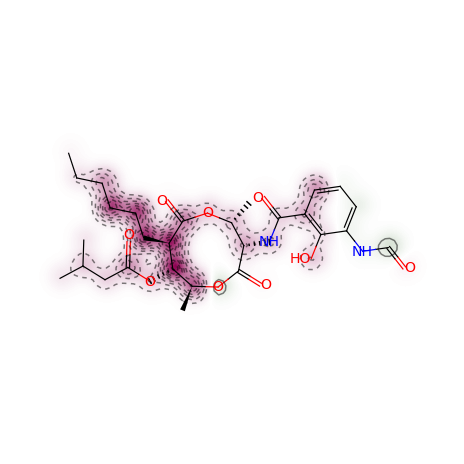

In [ ]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(Chem.MolFromSmiles('O=CNc1cccc(c1O)C(=O)N[C@@H]2C(=O)O[C@H]([C@H](OC(=O)CC(C)C)[C@H](C(=O)O[C@@H]2C)CCCCCC)C'), weights_mu)

In [ ]:
X_toshap = torch.from_numpy(shap.sample(X_test,100)).float()
explainer = DeepExplainer(model, X_toshap)
shapv = explainer.shap_values(X_toshap)
preds = model(X_toshap)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
y_mu, y_sigma = model.predict_normal_distribution(torch.from_numpy(X_test).float(), n_samples = 1000)

y_pred = [int(x>0) for x in y_mu]
print(balanced_accuracy_score(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))

0.8049786679139913
0.6102999910153232


In [ ]:
for i in range(20): 
    probs = model(torch.from_numpy(X_test).float()).data
    _, predictions = torch.max(probs, 1)
    y_pred = predictions.numpy()

    print('Run:', i+1)
    print('- Bal Acc: %f %%' % (balanced_accuracy_score(y_test, y_pred)))
    print('- MCC: %f' % (matthews_corrcoef(y_test, y_pred)))
    print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))



Run: 1
- Bal Acc: 0.785917 %
- MCC: 0.572156
- CE : 0.03, KL : 0.64
Run: 2
- Bal Acc: 0.782194 %
- MCC: 0.568343
- CE : 0.03, KL : 0.64
Run: 3
- Bal Acc: 0.799238 %
- MCC: 0.598503
- CE : 0.03, KL : 0.64
Run: 4
- Bal Acc: 0.788874 %
- MCC: 0.578107
- CE : 0.03, KL : 0.64
Run: 5
- Bal Acc: 0.778411 %
- MCC: 0.556823
- CE : 0.03, KL : 0.64
Run: 6
- Bal Acc: 0.779108 %
- MCC: 0.562555
- CE : 0.03, KL : 0.64
Run: 7
- Bal Acc: 0.791756 %
- MCC: 0.585433
- CE : 0.03, KL : 0.64
Run: 8
- Bal Acc: 0.789818 %
- MCC: 0.581997
- CE : 0.03, KL : 0.64
Run: 9
- Bal Acc: 0.801633 %
- MCC: 0.604334
- CE : 0.03, KL : 0.64
Run: 10
- Bal Acc: 0.770627 %
- MCC: 0.543852
- CE : 0.03, KL : 0.64
Run: 11
- Bal Acc: 0.789818 %
- MCC: 0.581997
- CE : 0.03, KL : 0.64
Run: 12
- Bal Acc: 0.798645 %
- MCC: 0.600083
- CE : 0.03, KL : 0.64
Run: 13
- Bal Acc: 0.796714 %
- MCC: 0.593083
- CE : 0.03, KL : 0.64
Run: 14
- Bal Acc: 0.794139 %
- MCC: 0.590214
- CE : 0.03, KL : 0.64
Run: 15
- Bal Acc: 0.799824 %
- MCC: 0.6007